# Inputs to a Pre-trained GAN

### Goal
You are going to begin playing with generators and see how they fit into machine learning and generative adversarial networks (GANs). You will get to run a pre-trained GAN, mess with the inputs, and check out the wacky outputs.

In the teaser, you saw some cool outputs. How does this all work? You will dive a little deeper in this notebook and see!

### Learning Objectives
1. Gain familiarity with how GANs work (discriminator + generator).
2. Explore the impact of noise vectors and truncation.
3. Adapt inputs to the generator to generate different faces.






## Discriminator vs. Generator
The first thing that you will get to explore is the difference between a discriminator and a generator. Remember that these are the two main components of a GAN!

#### What is a discriminator?

One of the most widely used type of ML models is the classifier, which is used to sift through items in a dataset and classify them into different categories. For example, you might be familiar with image classifiers that discriminate between images of a cat and images of a dog. For a well-trained classifier: when you give it an image of a cat, it will say "cat"! When you give it an image of a dog, it will say "dog"! You can also use other classes, like coconuts vs. starfruit.

<img src="https://lh3.googleusercontent.com/2blMv3QiuuIb-lTccsI0SUODvmuhwKdNpU9M6eXMCKbg27vgXIB7aSJDf3csyGr8yeFVxQWDIcAg7L0VVteO-4zkENqbboi0VyqF_g=w2880-l80-sg" alt="discriminative model" width="400" align="center"/>

> *Image Credit: [Google](https://about.google/stories/machine-learning-qa/)*

In terms of probabilities, the classifier wants to find $p(y|x)$: the probability that given an image input $x$, the image class $y$ is cat, $p(y=\text{cat}|x)$, or dog, $p(y=\text{dog}|x)$.

The discriminator is simply a classifier with two classes: real and fake. Given an input x, the discriminator will calculate the probabilities $p(y=\text{real}|x)$ and $p(y=\text{fake}|x)$ and classify $x$. The input $x$ can be anything that you have the generator create and is not limited to images. Your GAN can be trained on videos, text, audio, etc.


#### What is a generator?

Generators are designed to have a different goal from discriminators (classifiers). Imagine you're working at a tropical fruit stand and asked to sort the fruit into two categories: coconuts and starfruit. That's the job of a classifier. But what if a customer comes up to the stand, and asks: what is a starfruit? You can't just say that it's not a coconut. You would need to explain what makes something a starfruit and what doesn't, not just its differences from a coconut. That's the job of a generator: to represent different classes in general, not just distinguish them. 

In terms of probabilities, the generator wants to figure out $p(x|y)$: the probability that, given that you generated a starfruit $(y=\text{starfruit})$, the resulting image $(x)$ is the one generated. The output space of possible starfruit images is huge, so that makes this challenging for the generator.

This can be a much harder task than discrimination. Typically, you will need the generator to take multiple steps to improve itself for every step the discriminator takes. It's easy to tell the difference between a coconut and a starfruit when you look at a mix of them, but to know exactly all the features of all possible coconuts in the world? That's a lot, but it's really cool if you can get even close to it, because you can start generating all sorts of coconuts and starfruit when you do. I don't have a generator for these tropical fruits figured out for you to play with, but you can generate all kinds of cool things with these models, like realistic faces!

In the below image, the generator is trying to find the features that represent all cats using the feedback from the discriminator.

<img src="https://www.tensorflow.org/tutorials/generative/images/gan2.png" width="500" display="block" align="center"/>

>*Image Credit: TensorFlow*





## Noise vector $z$

The noise vector $z$ has the important role of making sure the images generated from the same class $y$ don't all look the same—think of it as a random seed. You generate it randomly, usually by sampling random numbers either between 0 and 1 uniformly, or from the normal distribution, which you can denote $z$ ~ $N(0, 1)$. The zero means the normal distribution has a mean of zero, and the 1 means that the normal distribution has a variance of 1. 

In reality, $z$ is usually larger than just 1 value to allow for more combinations of what $z$ could be. There's no special number that determines what works, but 100 is standard. Some researchers might use a power of 2, like 128 or 512, but again, nothing special about the number itself, just that it's large enough to contain a lot of possibilities. As a result, you would sample $z$ from that many different dimensions (constituting multiple normal distributions).

*Fun Fact: this is also called a spherical normal and denoted $z$ ~ $N(0, I)$ where the $I$ represents the identity matrix and means the variance is 1 in all dimensions.*

## Truncation trick

So now that you're a bit familiar with noise vectors, here's another cool concept that people use to tune their outputs. It's called the truncation trick. I like to think of the truncation trick as a way of trading off fidelity (quality) and diversity in the samples. It works like this: when you randomly sample your noise vector $z$, you can choose to keep that random $z$ or you can sample another one. 

Why would you want to sample another one? 

Well, since I'm sampling $z$ from a normal distribution, my model will see more of those $z$ values within a standard deviation from the mean than those at the tails of the distribution—and this happens during training. This means that while the model is training, it's likely to be familiar with certain noise vectors and as a result model those areas coming from familiar noise vector regions. In these areas, my model will likely have much more realistic results, but nothing too funky, it's not taking as many risks in those regions mapped from those familiar noise vectors. This is the trade-off between fidelity (realistic, high quality images) and diversity (variety in images). 

<img src="https://build.openmodelica.org/Documentation/Modelica%203.2.3/Resources/Images/Math/Distributions/TruncatedNormal.density.png" alt="truncated normal distribution" width="400"/>

> *Image Credit: Modelica*


What the truncation trick does is resamples the noise vector $z$ until it falls within some bounds of the normal distribution. In fact, it samples $z$ from a truncated normal distribution where the tails are cut off at different values (red line in graph is truncated normal, blue is original). You can tune these values and thus tune fidelity/diversity. Recall that having a lot of fidelity is not always the goal—one failure mode of that is that you get one really real image but nothing else (no diversity), and that's not very interesting or successful from a model that's supposed to model the realm of all possible human faces or that of all possible coconuts—including that of a cat pouncing after a flying coconut (but with extremely low probability).

## Playing with code
You're going to play with the unconditional generator from StyleGAN to generate some faces. Notice how sometimes they look super realistic, and other times, well, hope you're not too scared of the uncanny valley. As you play more with these, you might grow to love them all the same, especially when you contrast it to where they began: pure random noise, as in completely random pixel values that look like static, learning over time to become face-like.

Start by running the following code block to load the model and import some libraries you will be using! (Don't worry about any errors regarding tensorflow 2.2.0 or warnings you may see)

In [1]:
# Clone the official StyleGAN repository from GitHub
!git clone https://github.com/NVlabs/stylegan.git

Cloning into 'stylegan'...
remote: Enumerating objects: 86, done.
remote: Total 86 (delta 0), reused 0 (delta 0), pack-reused 86
Unpacking objects: 100% (86/86), done.


In [2]:
%tensorflow_version 1.x
import os
import pickle
import numpy as np
import PIL.Image
import stylegan
from stylegan import config
from stylegan.dnnlib import tflib
from tensorflow.python.util import module_wrapper
module_wrapper._PER_MODULE_WARNING_LIMIT = 0

# Initialize TensorFlow
tflib.init_tf()

# Go into that cloned directory
path = 'stylegan/'
if "stylegan" not in os.getcwd():
    os.chdir(path)

# Load pre-trained network
# url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # Downloads the pickled model file: karras2019stylegan-ffhq-1024x1024.pkl
url = 'https://bitbucket.org/ezelikman/gans/downloads/karras2019stylegan-ffhq-1024x1024.pkl'
with stylegan.dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
  print(f)
  _G, _D, Gs = pickle.load(f)
#   Gs.print_layers()  # Print network details

TensorFlow 1.x selected.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Now you can use this separate script to play with the model without needing to reload it everytime (that would take a while).

Feel free to mess with any of the code but here are some values you can try modifying:
  *   `rnd`: The random seed that generates the noise vectors. Changing this will change the noise vectors fed to the generator; see what happens next!
  *   `batch_size`: This is the number of images that you want generated.
  *   `truncation`: The positive truncation value. 1 is low truncation (high diversity) and 0 is all truncation except for the mean (high quality/fidelity). A lower value increases fidelity and decreases diversity, and vice versa. These are trade-offs that you can play with.



Noise vector has size 512


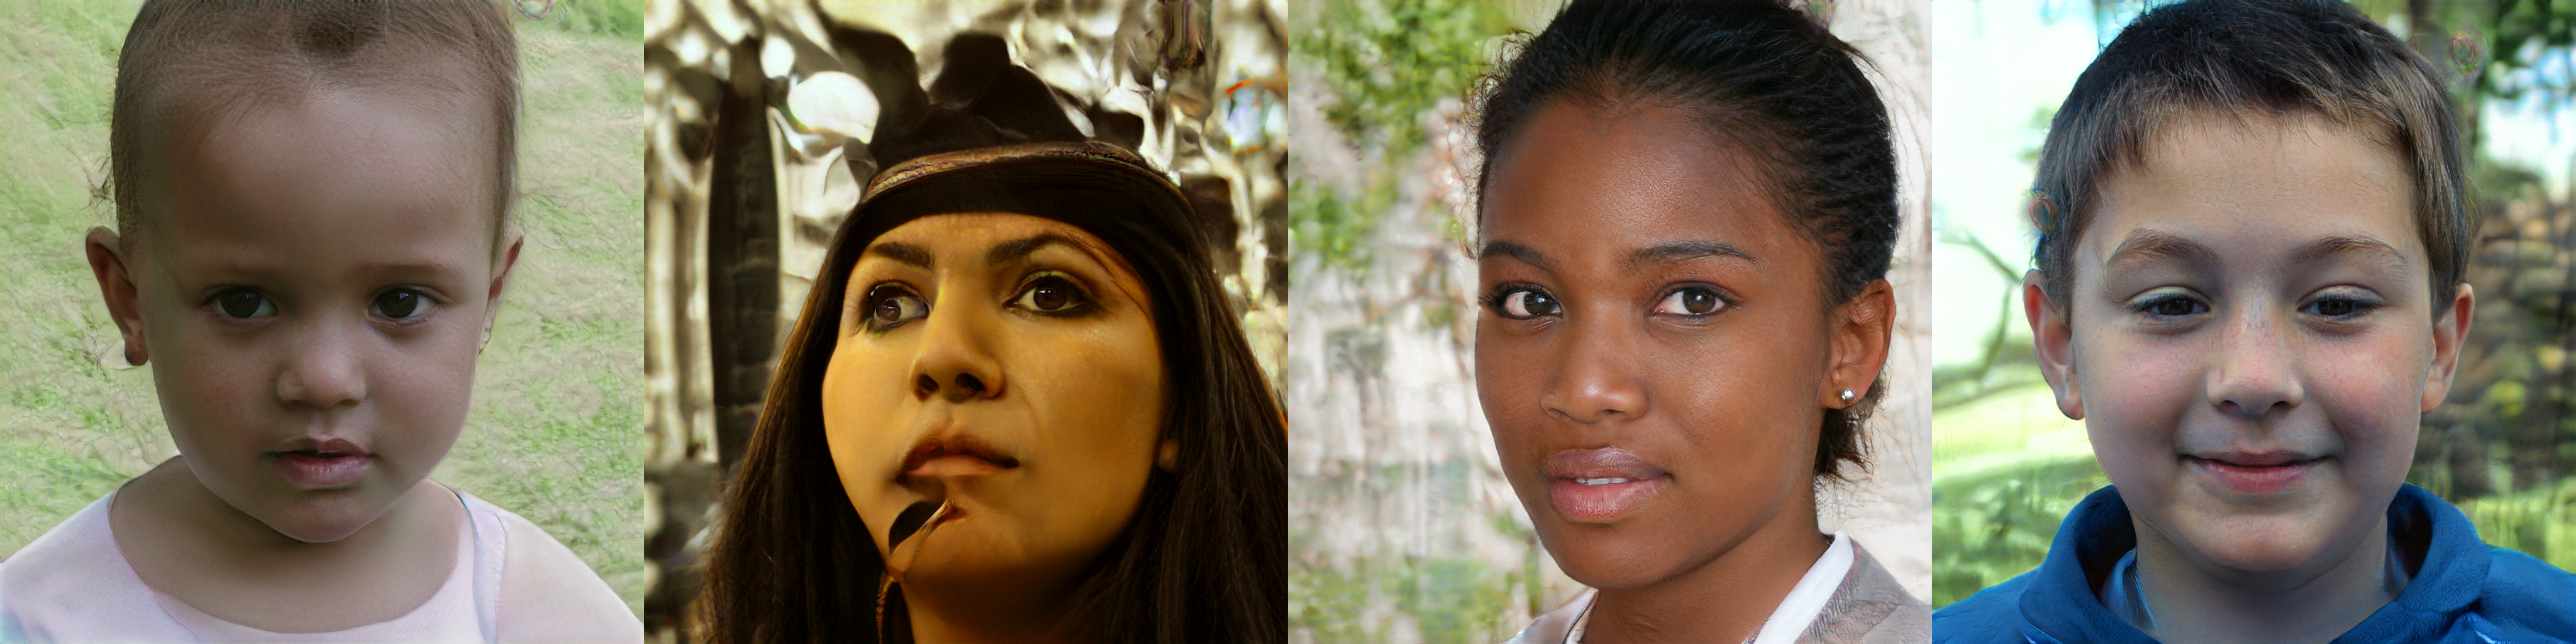

In [3]:
# Set the random seed that generates the noise vectors
rnd = np.random.RandomState(42)

# Set the number of images to generate
batch_size = 4

# Set the truncation value for truncation trick sampling
truncation = 0.7

# Create a noise vector z for each sample in the batch: (batch_size, z_dim)
z_dim = Gs.input_shape[1] # StyleGAN authors use the image dim (512) as the size of z
print(f'Noise vector has size {z_dim}')
noise_vectors = rnd.randn(batch_size, z_dim)

# Generate image by running (sampling) the generator
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True) # Specify the desired output format and shape
images = Gs.run(noise_vectors,
                None,    # No labels/conditions because it is unconditional generation (more on this in the coming lectures)
                truncation_psi=truncation, 
                randomize_noise=False,
                output_transform=fmt
                )

# Display images
if batch_size > 1:
  img = np.concatenate(images, axis=1) # Save all images in batch to a single image
else:
  img = images[0]
PIL.Image.fromarray(img, 'RGB')

Here's another script to help familiarize you with what interpolation in GANs can look like—filling in the unknown between two objects. In this case, you are using face images where the GAN will fill in how one image can morph into another. You will generate random noise vectors for the start and end images and then create noise vectors for the the ones inbetween.

Again, feel free to mess with any of the code but here are some values you should try modifying:
  *   `rnd`: The random seed that generates the noise vectors. Changing this will change the noise vectors fed to the generator and, consequently, the images generated!
  *   `truncation`: The truncation value between 0 and 1. 1 is no truncation (high diversity) and 0 is all truncation except for the mean (high quality/fidelity). A lower value increases fidelity and decreases diversity, and vice versa. These are trade-offs that you can play with.
  *   `n_interpolations`: The number of images that you want generated. A 3 would mean there is one transition photo between the start and end photos. If you want to see an interpolation, this value should be greater than 2.

*Fun Fact: interpolations do not have to be not nearly as smooth as the ones produced by StyleGAN. In fact, StyleGAN has a few tricks specifically to make it learn smooth interpolations!*

In [4]:
# Set the random seed that generates the noise vectors
rnd = np.random.RandomState(4)

# Set the truncation value for truncation trick sampling
truncation = 0.7

# Set the number of interpolations/number of images to generate
n_interpolation = 10

# Create a noise vector z for the start and end images (batch_size = 1 since they are single image): (batch_size, z_dim)
# And create noise for the interpolations inbetween
z_dim = Gs.input_shape[1]
first_noise = rnd.randn(1, z_dim)
second_noise = rnd.randn(1, z_dim)
percent_first_noise = np.linspace(0, 1, n_interpolation)[:, None]
interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

# Generate image by running (sampling) the generator
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True) # Specify the desired output format and shape
images = Gs.run(interpolation_noise,
                None,    # No labels/conditions because it is unconditional generation!
                truncation_psi=truncation, 
                randomize_noise=False,
                output_transform=fmt
                )

# Display images
if batch_size > 1:
  img = np.concatenate(images, axis=1) # Save all images in batch to a single image
else:
  img = images[0]
PIL.Image.fromarray(img, 'RGB')